# NMP Python Project on Predictive Modelling with a Multi-Layer Perceptron Regressor
SoSe 2021, SCAN Master FU Berlin

## What Data do we have:
From Kaggle TReNDS Competition (https://www.kaggle.com/c/trends-assessment-prediction/data) 


<u>**How Features Were Obtained**</u>

An unbiased strategy was utilized to obtain the provided features. This means that a separate, unrelated large imaging dataset was utilized to learn feature templates. Then, these templates were "projected" onto the original imaging data of each subject used for this competition using spatially constrained independent component analysis (scICA) via group information guided ICA (GIG-ICA).

The first set of features are source-based morphometry (SBM) loadings. These are subject-level weights from a group-level ICA decomposition of gray matter concentration maps from structural MRI (sMRI) scans.

The second set are static functional network connectivity (FNC) matrices. These are the subject-level cross-correlation values among 53 component timecourses estimated from GIG-ICA of resting state functional MRI (fMRI).


<u>**Objective of this Notebook**</u>
- Import and select data for predicting (age & assessment scores)
- Compare different MLPRegressor Models that best can predict the data given certain parameters and input data
- How well does the MLPRegressor predict the individual dependent variables vs. using it as MultiOutputRegressor
- Difference between intrinsic multi output in scikit learns MLPRegressor and the additional MultiOutputRegressor add on
- Take one model (the one with the best performance) and its score & compare with other models predicting same variable (group work, other models not shown here)

#### We start with loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn import metrics
import os

#### Now lets check that the data is there. We need loading.csv, train_scores.csv & fnc.csv

In [2]:
os.listdir()

['.DS_Store',
 'loading.csv',
 'NMPProject_MLPRegressor.ipynb',
 'train_scores.csv',
 '.ipynb_checkpoints',
 'fnc.csv',
 'Not_Important']

In [3]:
#now we'll load the data
loading_df = pd.read_csv('loading.csv')
fnc_df = pd.read_csv("fnc.csv")
train_df = pd.read_csv("train_scores.csv")

#### Check the data 
- we adittionally want the column names to later access only them for making our X & y data frames

In [4]:
fnc_names = list(fnc_df.columns[1:])
print('shape: ', fnc_df.shape)
#since we have a lot of columns, we will scale the fnc features down a bit to prevent overfitting
scale_fnc = 1/500
fnc_df[fnc_names] *= scale_fnc
fnc_df.head()

shape:  (11754, 1379)


,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,0.000737,0.000334,0.000876,0.000682,-0.000373,0.000098,0.000243,-0.000349,-0.000463,...,-0.000299,0.001106,0.000262,0.000671,0.000790,-0.000086,0.000249,-0.000121,0.001032,0.000581
1,10002,0.000303,-0.000050,0.000435,0.000836,-0.000454,-0.000128,-0.000288,-0.000236,-0.000110,...,-0.000428,-0.000080,0.000286,-0.000380,0.000997,0.000888,0.001185,0.000057,0.001411,0.000497
2,10003,0.000687,0.000220,0.001483,0.001157,-0.001353,-0.000874,-0.000591,-0.000756,-0.000690,...,-0.000310,0.000274,-0.000045,0.000275,0.001356,0.000819,0.001128,0.000877,0.001236,0.000569
3,10004,0.000266,0.000517,0.000982,0.000685,0.000182,0.000216,0.000058,-0.000052,0.000189,...,-0.000261,0.000619,0.000283,0.000062,0.000689,0.000428,0.000635,0.000025,0.001332,0.000163
4,10005,0.000584,0.000503,0.000833,0.001023,-0.000725,-0.000329,-0.000578,-0.000031,-0.000175,...,-0.000279,0.000790,0.000081,0.000857,0.000998,0.000534,0.000455,0.000058,0.001505,0.000176


In [5]:
loading_names = list(loading_df.columns[1:])
print('shape: ', loading_df.shape)
loading_df.head()

shape:  (11754, 27)


,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
0,10001,0.006070,0.014466,0.004136,0.000658,-0.002742,0.005033,0.016720,0.003484,0.001797,...,0.018246,0.023711,0.009177,-0.013929,0.030696,0.010496,0.002892,-0.023235,0.022177,0.017192
1,10002,0.009087,0.009291,0.007049,-0.002076,-0.002227,0.004605,0.012277,0.002946,0.004086,...,0.014635,0.022556,0.012004,-0.011814,0.022479,0.005739,0.002880,-0.016609,0.025543,0.014524
2,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
3,10004,0.004675,0.000957,0.006154,-0.000429,-0.001222,0.011755,0.013010,0.000193,0.008075,...,0.002658,0.022266,0.005956,-0.010595,0.024078,-0.000319,0.005866,-0.015182,0.024476,0.014760
4,10005,-0.000398,0.006878,0.009051,0.000369,0.000336,0.010679,0.010352,0.003637,0.004180,...,0.009702,0.017257,0.005454,-0.008591,0.019416,0.000786,0.002692,-0.019814,0.017105,0.013316


In [6]:
loading_plus_fnc = loading_df.merge(fnc_df, on="Id",)
print('shape: ', loading_plus_fnc.shape)
loading_plus_fnc.head()

shape:  (11754, 1405)


,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,0.006070,0.014466,0.004136,0.000658,-0.002742,0.005033,0.016720,0.003484,0.001797,...,-0.000299,0.001106,0.000262,0.000671,0.000790,-0.000086,0.000249,-0.000121,0.001032,0.000581
1,10002,0.009087,0.009291,0.007049,-0.002076,-0.002227,0.004605,0.012277,0.002946,0.004086,...,-0.000428,-0.000080,0.000286,-0.000380,0.000997,0.000888,0.001185,0.000057,0.001411,0.000497
2,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,-0.000310,0.000274,-0.000045,0.000275,0.001356,0.000819,0.001128,0.000877,0.001236,0.000569
3,10004,0.004675,0.000957,0.006154,-0.000429,-0.001222,0.011755,0.013010,0.000193,0.008075,...,-0.000261,0.000619,0.000283,0.000062,0.000689,0.000428,0.000635,0.000025,0.001332,0.000163
4,10005,-0.000398,0.006878,0.009051,0.000369,0.000336,0.010679,0.010352,0.003637,0.004180,...,-0.000279,0.000790,0.000081,0.000857,0.000998,0.000534,0.000455,0.000058,0.001505,0.000176


In [7]:
voi_names = list(train_df.columns[1:])
print('shape: ', train_df.shape)
train_df.head()

shape:  (5877, 6)


,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421


#### Also, lets already make a function that gives us back scores, both the R2 and the Mean Absolute Percentage Error


In [8]:
#get score function
def print_scores(ytrue, ypred, method = 'Single'):
    if method == 'Multi':
        print('raw values of R2: ', metrics.r2_score(y_true=ytrue, y_pred=ypred, multioutput='raw_values'))
        print('\nvariance weighted total R2: ', metrics.r2_score(y_true=ytrue, y_pred=ypred, multioutput='variance_weighted'))
        print('\naverage total R2: ', metrics.r2_score(y_true=ytrue, y_pred=ypred, multioutput='uniform_average'))
        print('\nMean Absolute Percentage Error (average): ', np.mean(np.sum(np.abs(ytrue - ypred), axis=0)/np.sum(ytrue, axis=0)))
        print('\nMean Absolute Percentage Error (raw) : \n', np.sum(np.abs(ytrue - ypred), axis=0)/np.sum(ytrue, axis=0), sep='')
    elif method == 'Single':
        print('total R2: ', metrics.r2_score(y_true=ytrue, y_pred=ypred))
        print('\nMean Absolute Percentage Error: ', np.mean(np.sum(np.abs(ytrue - ypred), axis=0)/np.sum(ytrue, axis=0)))



#### Lets look at the distribution of target variables and their correlations

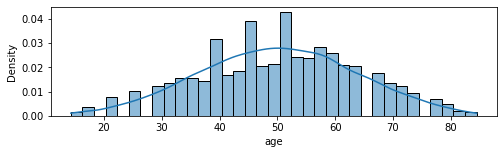

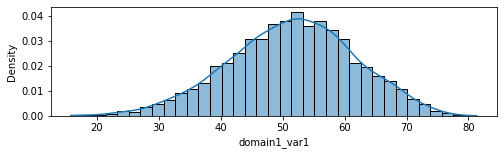

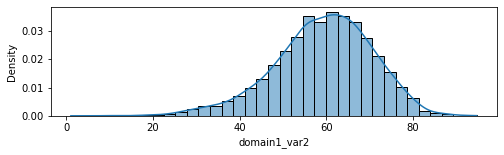

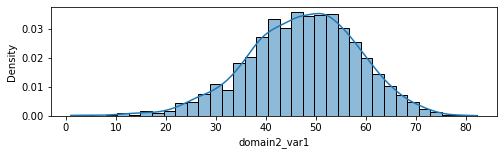

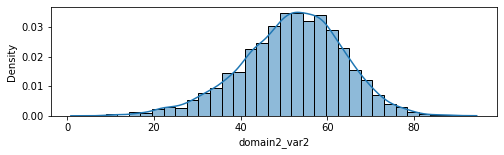

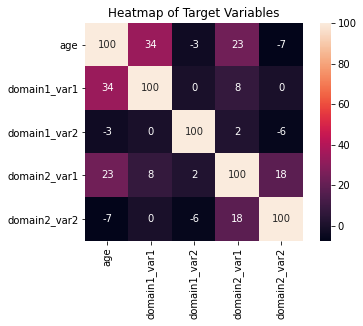

In [9]:
from scipy.stats import norm
for col in train_df.columns[1:]:
    plt.figure(figsize=(8, 2))
    sns.histplot(train_df[col], stat = 'density', kde = True, bins= 35) 
    #older seaborn versions need to use sns.distplot with the arguments listed below
    #sns.distplot(train_df[col], fit=norm, kde=True)
    plt.show()

sns.heatmap(train_df.iloc[:,1:].corr()*100, square=True, annot=True, fmt='.0f')
plt.title('Heatmap of Target Variables')
plt.show()

Somewhat correlation between var1 in both domain1 & domain 2 and age as well as in domain2, but we won't worry about this since it isn't too high.

#### Now lets look at the correlation of features in the sMRI loading data. For NN, it does not have that big of an effect (https://datascience.stackexchange.com/questions/28328/how-does-multicollinearity-affect-neural-networks), but we it might still be good.

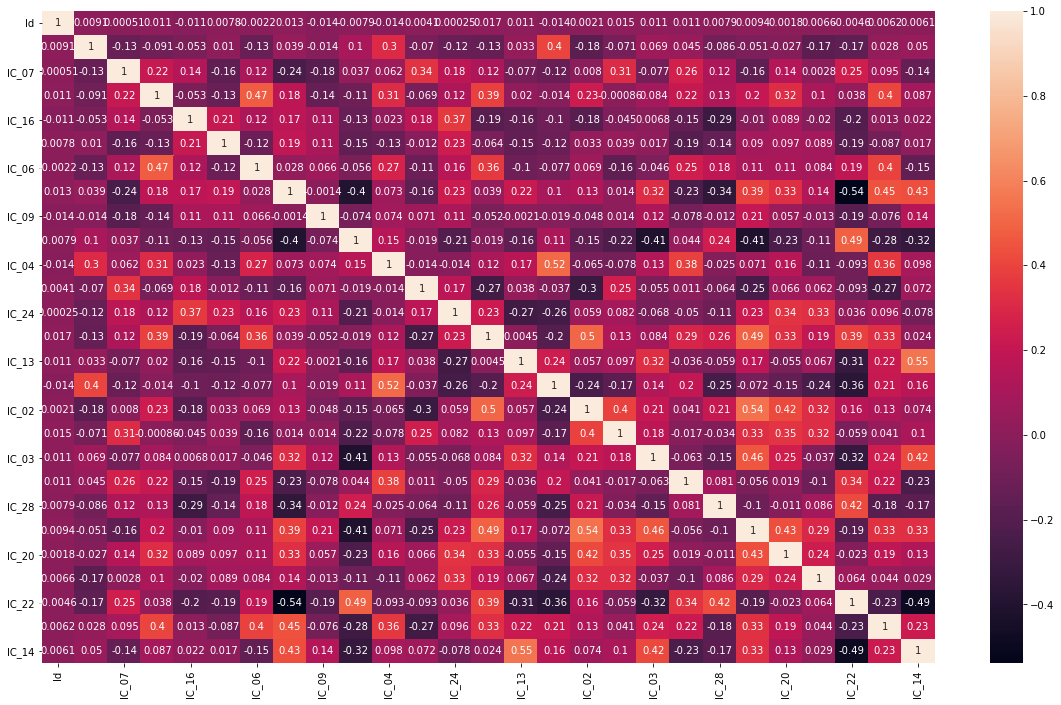

In [10]:
sns.heatmap(loading_df.corr(), annot=True )
fig=plt.gcf()
fig.set_size_inches(20,12)

A few somewhat high correlations (>0.5), lets take them out

In [11]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(loading_df, 10)) # remove IC 13,2,10,4

Top Absolute Correlations
IC_13  IC_14    0.549198
IC_02  IC_11    0.541680
IC_10  IC_22    0.539141
IC_04  IC_17    0.517069
IC_15  IC_02    0.502258
IC_22  IC_14    0.490677
IC_15  IC_11    0.489176
IC_18  IC_22    0.486763
IC_05  IC_06    0.473493
IC_03  IC_11    0.456074
dtype: float64


Removing IC 13,2,10 & 4 will leave us with all feature correlations below 0.5, 

In [12]:
print('ICs (before): \n{}'.format(np.sort(loading_df.columns)), sep='')
loading_df = loading_df.drop(['IC_02', 'IC_04', 'IC_10', 'IC_13'], 1)
print('\nICs (after): \n{}'.format(np.sort(loading_df.columns)), sep='')
#we also need to update our loadings names, since that list contains the removed ICs
print('\n\nloading_names (before): \n{}'.format(loading_names))
loading_names = list(loading_df.columns[1:])
print('\nloading_names (updated): \n{}'.format(loading_names))

ICs (before): 
['IC_01' 'IC_02' 'IC_03' 'IC_04' 'IC_05' 'IC_06' 'IC_07' 'IC_08' 'IC_09'
 'IC_10' 'IC_11' 'IC_12' 'IC_13' 'IC_14' 'IC_15' 'IC_16' 'IC_17' 'IC_18'
 'IC_20' 'IC_21' 'IC_22' 'IC_24' 'IC_26' 'IC_28' 'IC_29' 'IC_30' 'Id']

ICs (after): 
['IC_01' 'IC_03' 'IC_05' 'IC_06' 'IC_07' 'IC_08' 'IC_09' 'IC_11' 'IC_12'
 'IC_14' 'IC_15' 'IC_16' 'IC_17' 'IC_18' 'IC_20' 'IC_21' 'IC_22' 'IC_24'
 'IC_26' 'IC_28' 'IC_29' 'IC_30' 'Id']


loading_names (before): 
['IC_01', 'IC_07', 'IC_05', 'IC_16', 'IC_26', 'IC_06', 'IC_10', 'IC_09', 'IC_18', 'IC_04', 'IC_12', 'IC_24', 'IC_15', 'IC_13', 'IC_17', 'IC_02', 'IC_08', 'IC_03', 'IC_21', 'IC_28', 'IC_11', 'IC_20', 'IC_30', 'IC_22', 'IC_29', 'IC_14']

loading_names (updated): 
['IC_01', 'IC_07', 'IC_05', 'IC_16', 'IC_26', 'IC_06', 'IC_09', 'IC_18', 'IC_12', 'IC_24', 'IC_15', 'IC_17', 'IC_08', 'IC_03', 'IC_21', 'IC_28', 'IC_11', 'IC_20', 'IC_30', 'IC_22', 'IC_29', 'IC_14']


#### Now lets look at the data again and if there is anything else

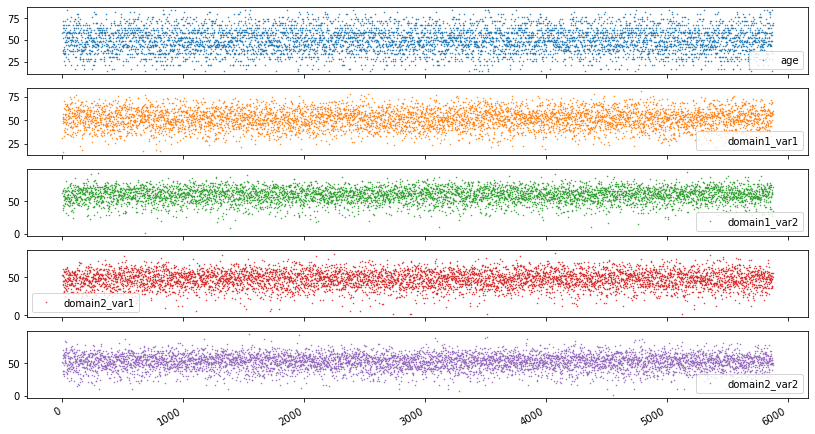

In [13]:
train_df.iloc[:,1:].plot(lw=0, marker='.', markersize=1, subplots=True, figsize=(14, 8))
plt.show()

Age looks like it has discrete categories, we can check:

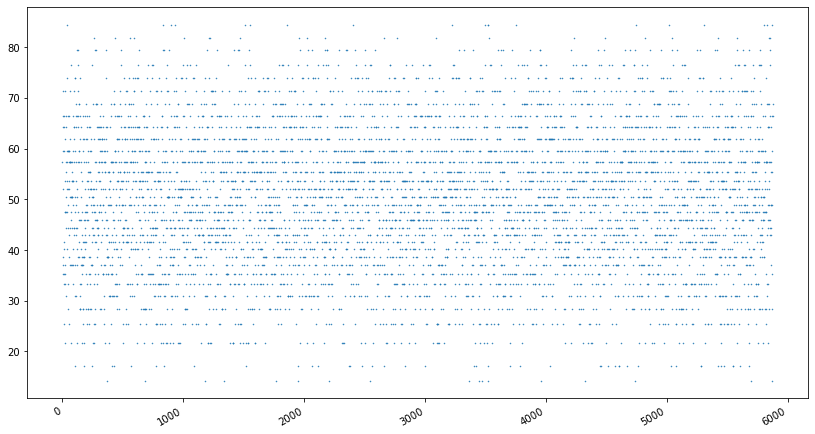

In [14]:
train_df['age'].plot(lw=0, marker='.', markersize=1, subplots=True, figsize=(14, 8))
plt.show()

number of unique age values: 
33

unique age values (sorted): 
[14.25726522 17.22458014 21.74381885 25.39336169 28.44274169 30.99738266
 33.40469072 35.3265819  36.96117389 38.61738057 40.12936066 41.51720254
 42.94115369 44.42390642 45.8882136  47.47020319 48.94875626 50.42774666
 51.99651429 53.5838048  55.45697773 57.43607707 59.58085067 61.81138167
 64.20310694 66.53262952 68.82092847 71.41301813 73.87045558 76.53864269
 79.41543791 81.9080382  84.49111251]


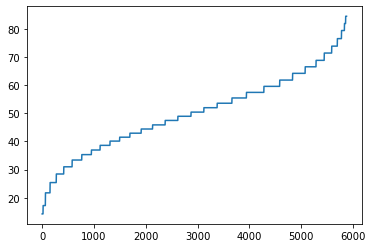

In [15]:
print("number of unique age values: \n", train_df['age'].nunique(), sep='')
print("\nunique age values (sorted): \n",np.sort(train_df['age'].unique()), sep='')
#distribution of age over target
plt.plot(train_df['age'].sort_values().values)
plt.show()

So there are 33 unique values for age, so it might be better to run a classifier on them, but we can look at that later.

#### Now back to setting up the data so we can predict our variables

In [16]:
fnc_loading_all = train_df.merge(loading_plus_fnc, on="Id", how="left")
fnc_all = train_df.merge(fnc_df, on="Id", how="left")
loading_all= train_df.merge(loading_df, on="Id")
print(fnc_loading_all.shape, fnc_all.shape, loading_all.shape) 
#all have the same amount of observarions and only have the data for the observations where the ground truth is available

(5877, 1410) (5877, 1384) (5877, 28)


In [17]:
#initializing X & Y (we can see if we might just want to take loading or fnc or both for better performance)
X_loading = loading_all[loading_names]
X_fnc = fnc_all[fnc_names]
X_fnc_loading = fnc_loading_all[fnc_names + loading_names]
y = train_df[voi_names]

In [18]:
#making train & test sets for loading and see how well this does
X_train, X_test, y_train, y_test = train_test_split(X_loading, y, test_size=0.25, random_state=10)

#### We can first check a linear regression model and see the performance for a simple linear model

In [19]:
#linear regression as first model
LinReg = LinearRegression()
for target in voi_names:
    print('\n{}: '.format(target), sep='')
    LinReg.fit(X_train[y_train[target].notnull()], y_train[target][y_train[target].notnull()])
    print_scores(ytrue=y_test[target][y_test[target].notnull()], ypred=LinReg.predict(X_test[y_test[target].notnull()]))
    print('\nR2 on training data: {} \n'.format(LinReg.score(X_train[y_train[target].notnull()], y_train[target][y_train[target].notnull()])))


age: 
total R2:  0.44335730287272934

Mean Absolute Percentage Error:  0.16288351500298312

R2 on training data: 0.4559518249008563 


domain1_var1: 
total R2:  0.0763872023614598

Mean Absolute Percentage Error:  0.1524553642657621

R2 on training data: 0.08865902224316058 


domain1_var2: 
total R2:  0.010122826409749264

Mean Absolute Percentage Error:  0.15291406509442593

R2 on training data: 0.0063165867655066155 


domain2_var1: 
total R2:  0.00857337023154714

Mean Absolute Percentage Error:  0.19242934838251483

R2 on training data: 0.041922951941501974 


domain2_var2: 
total R2:  0.006665494563871555

Mean Absolute Percentage Error:  0.17463735494697566

R2 on training data: 0.02354580846823151 



So our linear model did ok on the age but not really good on the others, but when we look at the coeficients, we see really high values

In [20]:
for target in ['age']:
    print('\n{}: '.format(target), sep='')
    LinReg.fit(X_train[y_train[target].notnull()], y_train[target][y_train[target].notnull()])
    print_scores(ytrue=y_test[target][y_test[target].notnull()], ypred=LinReg.predict(X_test[y_test[target].notnull()]))
    print('\nCoefs for prediction: \n{}'.format(LinReg.coef_))


age: 
total R2:  0.44335730287272934

Mean Absolute Percentage Error:  0.16288351500298312

Coefs for prediction: 
[ 160.15150217  353.1637251   -27.00108086  163.86798429 -113.2952606
 -613.02026346  258.84465143 -203.75703302 -541.73110989 -292.53902101
 -528.30385975  -26.73340616  386.11721689   49.96655052 -559.17189316
   77.24501611 -279.05545962 -401.56052403 -168.44771457 -814.16695954
 -217.91903777 -309.50771559]


#### Lets now set up our MLPRegressor
First, we can do a GridSearch and check the parameters. However, we can already say that we want our neurons to be the mean of input and output layers (https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/1097#1097), and now we just want to check the parameters alpha for penalizing high weights and whether we want one or two hidden layers


In [21]:
hls = int(round((np.mean([len(X_loading.columns),1])))) #mean of input & output layers which will be the number of neurons
parameters_to_search = [{'alpha': list(10.0 ** -np.arange(0, 7))},
                         {'alpha': list(10.0 ** -np.arange(0, 7)), 'hidden_layer_sizes': [(hls, hls)]}]

mlpreg = MLPRegressor(hidden_layer_sizes=(hls,), max_iter=500, random_state=10)    


*I won't do this now, because it takes a while, but the output is summarized below.*

In [22]:
for target in voi_names:
    GridS = GridSearchCV(mlpreg, param_grid=parameters_to_search)
    GridS.fit(X_train[y_train[target].notnull()], y_train[target][y_train[target].notnull()])
    print('\n{}: '.format(target), sep='')
    print('Best Parameters: {} \n'.format(GridS.best_params_))
    print_scores(ytrue=y_test[target][y_test[target].notnull()], ypred=GridS.predict(X_test[y_test[target].notnull()]))

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war


age: 
Best Parameters: {'alpha': 1.0, 'hidden_layer_sizes': (12, 12)} 

total R2:  0.42755648719470174

Mean Absolute Percentage Error:  0.1650220981813768


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war


domain1_var1: 
Best Parameters: {'alpha': 1e-06, 'hidden_layer_sizes': (12, 12)} 

total R2:  0.05777326690198259

Mean Absolute Percentage Error:  0.15367427440311873


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war


domain1_var2: 
Best Parameters: {'alpha': 1.0, 'hidden_layer_sizes': (12, 12)} 

total R2:  0.002084061606523191

Mean Absolute Percentage Error:  0.15378440010364244


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war


domain2_var1: 
Best Parameters: {'alpha': 1e-06, 'hidden_layer_sizes': (12, 12)} 

total R2:  0.012026225835147897

Mean Absolute Percentage Error:  0.1926258790825083


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war


domain2_var2: 
Best Parameters: {'alpha': 1e-06, 'hidden_layer_sizes': (12, 12)} 

total R2:  0.005310524190425325

Mean Absolute Percentage Error:  0.17550618234398632


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


scores still look really bad... except for our age, which got an R2 of 0.42, but still no better than our linear regression, also surprising because age is actually not even continuous in our case.

- age: 

   - Best Parameters: {'alpha': 1.0, 'hidden_layer_sizes': (12, 12)} 

   - total R2:  0.42755648719470174

   - self computed Mean Absolute Percentage Error:  0.1650220981813768
    
- domain1_var1: 

   - Best Parameters: {'alpha': 1e-06, 'hidden_layer_sizes': (12, 12)} 

   - total R2:  0.05777326690198259

   - self computed Mean Absolute Percentage Error:  0.15367427440311873
   
- domain1_var2: 
    - Best Parameters: {'alpha': 1.0, 'hidden_layer_sizes': (12, 12)} 

    - total R2:  0.002084061606523191

    - self computed Mean Absolute Percentage Error:  0.15378440010364244
- domain2_var1: 
    - Best Parameters: {'alpha': 1e-06, 'hidden_layer_sizes': (12, 12)} 

    - total R2:  0.012026225835147897

    - self computed Mean Absolute Percentage Error:  0.1926258790825083
    
- domain2_var2: 
    - Best Parameters: {'alpha': 1e-06, 'hidden_layer_sizes': (12, 12)} 

    - total R2:  0.005310524190425325

    - self computed Mean Absolute Percentage Error:  0.17550618234398632


#### Now lets take those parameters and run the MLPRegressor again and also check the R2 on training data for overfitting

In [23]:
%%time
for target in voi_names:
    mlpreg = MLPRegressor(hidden_layer_sizes=(hls,hls), random_state=10, max_iter=500, alpha=0.000001, )
    if target == 'age' or target == 'domain1_var2':
        mlpreg.set_params(alpha = 1.0)
    print('\n{}: '.format(target), sep='')
    print(mlpreg)
    mlpreg.fit(X_train[y_train[target].notnull()], y_train[target][y_train[target].notnull()])
    print_scores(ytrue=y_test[target][y_test[target].notnull()], ypred=mlpreg.predict(X_test[y_test[target].notnull()]))
    print('\nR2 on training data: {} \n'.format(mlpreg.score(X_train[y_train[target].notnull()], y_train[target][y_train[target].notnull()])))


age: 
MLPRegressor(alpha=1.0, hidden_layer_sizes=(12, 12), max_iter=500,
             random_state=10)


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  0.42755648719470174

Mean Absolute Percentage Error:  0.1650220981813768

R2 on training data: 0.43674820524167823 


domain1_var1: 
MLPRegressor(alpha=1e-06, hidden_layer_sizes=(12, 12), max_iter=500,
             random_state=10)


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  0.05777326690198259

Mean Absolute Percentage Error:  0.15367427440311873

R2 on training data: 0.06512938411455294 


domain1_var2: 
MLPRegressor(alpha=1.0, hidden_layer_sizes=(12, 12), max_iter=500,
             random_state=10)
total R2:  0.002084061606523191

Mean Absolute Percentage Error:  0.15378440010364244

R2 on training data: -0.0002009362807902093 


domain2_var1: 
MLPRegressor(alpha=1e-06, hidden_layer_sizes=(12, 12), max_iter=500,
             random_state=10)


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  0.012026225835147897

Mean Absolute Percentage Error:  0.1926258790825083

R2 on training data: 0.030496290688078798 


domain2_var2: 
MLPRegressor(alpha=1e-06, hidden_layer_sizes=(12, 12), max_iter=500,
             random_state=10)
total R2:  0.005310524190425325

Mean Absolute Percentage Error:  0.17550618234398632

R2 on training data: 0.016814338526705108 

CPU times: user 49.9 s, sys: 155 ms, total: 50 s
Wall time: 25.2 s


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Lets try and see what scaling does to our data, since scaling is said to effect the performance of MLPRegressor:

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
for target in voi_names:
    mlpreg = MLPRegressor(hidden_layer_sizes=(hls,hls), max_iter=500, random_state=10, alpha=0.000001)
    if target == 'age' or target == 'domain1_var2':
        mlpreg.set_params(alpha = 1.0)
    print('\n{}: '.format(target), sep='')
    mlpreg.fit(scaler.transform(X_train[y_train[target].notnull()]), y_train[target][y_train[target].notnull()])
    print_scores(ytrue=y_test[target][y_test[target].notnull()], ypred=mlpreg.predict(scaler.transform(X_test[y_test[target].notnull()])))
    print('\nR2 on training data: {} \n'.format(mlpreg.score(scaler.transform(X_train[y_train[target].notnull()]), y_train[target][y_train[target].notnull()])))


age: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  0.43064729830082726

Mean Absolute Percentage Error:  0.16497663407883909

R2 on training data: 0.49785995914343073 


domain1_var1: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  -0.018614606662002542

Mean Absolute Percentage Error:  0.1593875790320289

R2 on training data: 0.17555343149422353 


domain1_var2: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  -0.04991164699737283

Mean Absolute Percentage Error:  0.15742339444999595

R2 on training data: 0.07777199330578777 


domain2_var1: 
total R2:  -0.0559536994075267

Mean Absolute Percentage Error:  0.19771484718644927

R2 on training data: 0.09678698932252949 


domain2_var2: 
total R2:  -0.05500863289404512

Mean Absolute Percentage Error:  0.17993949186022787

R2 on training data: 0.09739817773035242 



/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


scaling makes predicting the other domains even worse and stays about the same for age. However makes a somewhat better fit for training data, but that is not what we are looking for..

What about min-max scaling:

In [25]:
scaler = MinMaxScaler()
scaler.fit(X_train)
for target in voi_names:
    mlpreg = MLPRegressor(hidden_layer_sizes=(hls,hls), max_iter=500, random_state=10, alpha=0.000001)
    if target == 'age' or target == 'domain1_var2':
        mlpreg.set_params(alpha = 1.0)
    print('\n{}: '.format(target), sep='')
    mlpreg.fit(scaler.transform(X_train[y_train[target].notnull()]), y_train[target][y_train[target].notnull()])
    print_scores(ytrue=y_test[target][y_test[target].notnull()], ypred=mlpreg.predict(scaler.transform(X_test[y_test[target].notnull()])))
    print('\nR2 on training data: {} \n'.format(mlpreg.score(scaler.transform(X_train[y_train[target].notnull()]), y_train[target][y_train[target].notnull()])))


age: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  0.4359981588076858

Mean Absolute Percentage Error:  0.1645676863237526

R2 on training data: 0.4573319436962129 


domain1_var1: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  0.053918359071952415

Mean Absolute Percentage Error:  0.1541070821233645

R2 on training data: 0.06850420403750701 


domain1_var2: 
total R2:  -0.004368150962176243

Mean Absolute Percentage Error:  0.15407758953998965

R2 on training data: -0.00580389266761161 


domain2_var1: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  -0.000498971572009399

Mean Absolute Percentage Error:  0.19367999226470264

R2 on training data: 0.025704924741332347 


domain2_var2: 
total R2:  0.0031892600139072913

Mean Absolute Percentage Error:  0.1749541129807875

R2 on training data: 0.0079020025416906 



Also not better unfortunately.

#### What if we take the all the features, will this improve the score?

We'll start with one hidden layer:

In [26]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_fnc_loading, y, test_size=0.25, random_state=10)

In [27]:
%%time
#how many neurons in hidden layer? Lets take 1/4 this time since we have 1400+ features:
hidden_size_all = int(1/4*(len(X_fnc_loading.columns)+1))
for target in voi_names:
    all_mlpr = MLPRegressor(hidden_layer_sizes= (hidden_size_all,), alpha=0.001, 
                            #lets take the middle between the best found alphas, GridSearch would take too long. And just to see if we see an initial improvement here.
                            max_iter=500, random_state=10)
    print('\n{}: '.format(target), sep='')
    all_mlpr.fit(X_train_all[y_train_all[target].notnull()], y_train_all[target][y_train_all[target].notnull()])
    print_scores(ytrue=y_test_all[target][y_test_all[target].notnull()], ypred=all_mlpr.predict(X_test_all[y_test_all[target].notnull()]))
    print('\nR2 on training data: {} \n'.format(all_mlpr.score(X_train_all[y_train_all[target].notnull()], y_train_all[target][y_train_all[target].notnull()])))
    
    


age: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  0.504192946993049

Mean Absolute Percentage Error:  0.1532627487644357

R2 on training data: 0.5568674046593337 


domain1_var1: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  0.06709609784867898

Mean Absolute Percentage Error:  0.15382366297535793

R2 on training data: 0.1594629891449355 


domain1_var2: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  0.004522595695084508

Mean Absolute Percentage Error:  0.1536157228624564

R2 on training data: 0.05734086498016189 


domain2_var1: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  0.01838146049719025

Mean Absolute Percentage Error:  0.1917186469490446

R2 on training data: 0.11107963905007756 


domain2_var2: 
total R2:  0.025573201973008275

Mean Absolute Percentage Error:  0.17226435305597043

R2 on training data: 0.09112141951752617 

CPU times: user 25min 33s, sys: 7.05 s, total: 25min 40s
Wall time: 15min 29s


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


For age we can see a small improvement, but also still not a big improvement given the additional computational cost of including additional 1400 features. For the other targets, we are still quite low on the sores.

Now with 2 hidden layers:

In [28]:
%%time
for target in voi_names:
    all_mlpr = MLPRegressor(hidden_layer_sizes= (hidden_size_all,hidden_size_all), alpha=0.001, 
                            max_iter=500, random_state=10)
    print('\n{}: '.format(target), sep='')
    all_mlpr.fit(X_train_all[y_train_all[target].notnull()], y_train_all[target][y_train_all[target].notnull()])
    print_scores(ytrue=y_test_all[target][y_test_all[target].notnull()], ypred=all_mlpr.predict(X_test_all[y_test_all[target].notnull()]))
    print('\nR2 on training data: {} \n'.format(all_mlpr.score(X_train_all[y_train_all[target].notnull()], y_train_all[target][y_train_all[target].notnull()])))


age: 
total R2:  0.5115370240951242

Mean Absolute Percentage Error:  0.15108287839433931

R2 on training data: 0.6370646126053507 


domain1_var1: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  -0.07244088754956834

Mean Absolute Percentage Error:  0.16222428810885142

R2 on training data: 0.33758662819698837 


domain1_var2: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  -0.11493858919418498

Mean Absolute Percentage Error:  0.16326906489143012

R2 on training data: 0.20788333539586423 


domain2_var1: 


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


total R2:  -0.14877514724398022

Mean Absolute Percentage Error:  0.2073539342899405

R2 on training data: 0.2826540178708905 


domain2_var2: 
total R2:  -0.13752922947405666

Mean Absolute Percentage Error:  0.18779823828222933

R2 on training data: 0.25246817000737987 

CPU times: user 31min 37s, sys: 8.49 s, total: 31min 46s
Wall time: 33min 25s


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


The score improves for age here as well, but is still similar to with only one hidden layer. Additionally, we see that the model overfits substantially for the other domains with high R2 on the training data, but low performance on the test data. Given only minor improvements for additional computational cost as well as the overfitting for the other domains, we'll not further explore the single predictions based on all features.

Still doesn't look better unfortunately. And comes with a higher computational cost...

#### Now lets fit a MultiOutput Regressor, one time with all the features, and one time only the loading

For that, we have to remove all the nan that we have in the complete data set


In [29]:
all_nan_rem = fnc_loading_all.copy()
all_nan_rem = all_nan_rem.dropna()
y_na_rem = all_nan_rem[voi_names]
X_na_rem = all_nan_rem[fnc_names+loading_names]

In [30]:
#define train & test sets again
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_na_rem, y_na_rem, test_size=0.25, random_state=10)


In [31]:
%%time
self_mlpr_multi = MLPRegressor(hidden_layer_sizes= (hidden_size_all,hidden_size_all), alpha=0.00001, max_iter=500, random_state=10)
add_mlpr_multi = MultiOutputRegressor(self_mlpr_multi)

#own multioutput regressor of MLPRegressor
self_mlpr_multi.fit(X_train_multi, y_train_multi)
print('own MultiOutput (all features): \n')
print_scores(ytrue=y_test_multi, ypred=self_mlpr_multi.predict(X_test_multi), method="Multi")
print('\n\n')

#with MultiOutputRegressor AddOn
add_mlpr_multi.fit(X_train_multi, y_train_multi)
print('MultiOutput AddOn (all features): \n')
print_scores(ytrue=y_test_multi, ypred=add_mlpr_multi.predict(X_test_multi), method="Multi")


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


own MultiOutput (all features): 

raw values of R2:  [ 0.49272452  0.05823174 -0.06586705 -0.02129785 -0.01236672]

variance weighted total R2:  0.11984923526109117

average total R2:  0.09028492602611675

Mean Absolute Percentage Error (average):  0.16400321910423174

Mean Absolute Percentage Error (raw) : 
age             0.151167
domain1_var1    0.158797
domain1_var2    0.157642
domain2_var1    0.178643
domain2_var2    0.173766
dtype: float64





/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MultiOutput AddOn (all features): 

raw values of R2:  [ 0.45708787 -0.00816654 -0.06807813 -0.16883336 -0.07664788]

variance weighted total R2:  0.06090874705104606

average total R2:  0.027072390367617816

Mean Absolute Percentage Error (average):  0.1703190790117179

Mean Absolute Percentage Error (raw) : 
age             0.156712
domain1_var1    0.163657
domain1_var2    0.157837
domain2_var1    0.191888
domain2_var2    0.181502
dtype: float64
CPU times: user 30min 33s, sys: 10.2 s, total: 30min 44s
Wall time: 16min 35s


Everything just got a lot worse for all target variables.

What about taking only loading features again:

In [32]:
%%time
self_mlpr_multi = MLPRegressor(hidden_layer_sizes= (hls,hls), alpha=0.01, max_iter=500, random_state=10)
add_mlpr_multi = MultiOutputRegressor(self_mlpr_multi)

#own multioutput regressor of MLPRegressor
self_mlpr_multi.fit(X_train_multi[loading_names], y_train_multi)
print('own MultiOutput (just loading features): \n')
print_scores(ytrue=y_test_multi, ypred=self_mlpr_multi.predict(X_test_multi[loading_names]), method="Multi")
print('\nR2 on training data: {} \n'.format(metrics.r2_score(y_true= y_train_multi, 
                                                             y_pred= self_mlpr_multi.predict(X_train_multi[loading_names]), multioutput='raw_values')))
print('\n\n')
#with MultiOutputRegressor AddOn
add_mlpr_multi.fit(X_train_multi[loading_names], y_train_multi)
print('MultiOutput AddOn (just loading features): \n')
print_scores(ytrue=y_test_multi, ypred=add_mlpr_multi.predict(X_test_multi[loading_names]), method="Multi")
print('\nR2 on training data: {} \n'.format(metrics.r2_score(y_true= y_train_multi, 
                                                             y_pred= add_mlpr_multi.predict(X_train_multi[loading_names]), multioutput='raw_values')))


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


own MultiOutput (just loading features): 

raw values of R2:  [ 0.20586725  0.05514493 -0.06341214 -0.00115612 -0.0715778 ]

variance weighted total R2:  0.035637893042774184

average total R2:  0.02497322410698819

Mean Absolute Percentage Error (average):  0.1733924516014337

Mean Absolute Percentage Error (raw) : 
age             0.191436
domain1_var1    0.159142
domain1_var2    0.158591
domain2_var1    0.178937
domain2_var2    0.178856
dtype: float64

R2 on training data: [ 0.19581272  0.05666206 -0.05067435  0.03330232 -0.04044419] 






/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MultiOutput AddOn (just loading features): 

raw values of R2:  [ 0.42341536  0.05602284 -0.00066633  0.00554685  0.00782556]

variance weighted total R2:  0.12284531623842078

average total R2:  0.09842885554120655

Mean Absolute Percentage Error (average):  0.16493650645972777

Mean Absolute Percentage Error (raw) : 
age             0.161868
domain1_var1    0.159066
domain1_var2    0.153792
domain2_var1    0.177826
domain2_var2    0.172131
dtype: float64

R2 on training data: [ 0.40637845  0.06148956 -0.00157981  0.03159639  0.01300493] 

CPU times: user 57.9 s, sys: 204 ms, total: 58.1 s
Wall time: 29.2 s


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


We can see, without including the fnc features makes the model perform better.
Also, single regressions perform similarly to MultiOutput, so no big difference there.

So far, nothing really helps with predicting the assessment scores more accurately unfortunately.. And Nothing to help improve the regression on Age.

#### What we can do now is check a classification for the discrete age targets and see how the performance is there.

First, we'll make age into categories 0-32

In [33]:
y_age = y['age'].copy()
y_age = np.array(y_age)
print('transformation of age to discrete integer categories')
for i in range(0,y['age'].nunique()):
    print(i, np.sort(y['age'].unique())[i])
    y_age[y_age==np.sort(y['age'].unique())[i]] = int(i)
y_age = y_age.astype(np.int32)

transformation of age to discrete integer categories
0 14.2572652165398
1 17.2245801423098
2 21.743818848301807
3 25.393361689600606
4 28.442741694208003
5 30.997382663281805
6 33.4046907187588
7 35.3265819044859
8 36.9611738903941
9 38.617380566579705
10 40.1293606590094
11 41.5172025422158
12 42.9411536893684
13 44.4239064182427
14 45.8882136033761
15 47.47020319119601
16 48.948756262021504
17 50.42774666398021
18 51.9965142902002
19 53.5838048033636
20 55.45697773245181
21 57.4360770738362
22 59.5808506667844
23 61.8113816704625
24 64.2031069380242
25 66.5326295229651
26 68.82092846881561
27 71.413018125774
28 73.8704555779527
29 76.53864269242459
30 79.4154379056055
31 81.90803819838841
32 84.4911125111928


Now we can do a grid search again to find best parameters for the classifier. We'll take only loading features for now again.

In [34]:
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_loading, y_age, test_size=0.25, random_state=10)
y_class_test = y_class_test.astype(np.int32)
y_class_train = y_class_train.astype(np.int32)


In [35]:
Classif = MLPClassifier(hidden_layer_sizes=(hls,), max_iter=500, random_state=10) 
GridClass = GridSearchCV(Classif, param_grid=parameters_to_search)
GridClass.fit(X_class_train, y_class_train)
print('Best Parameters: {} \n'.format(GridClass.best_params_))



/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

Best Parameters: {'alpha': 0.001, 'hidden_layer_sizes': (12, 12)} 



In [36]:
Classif = MLPClassifier(hidden_layer_sizes=(hls,hls), max_iter=500, random_state=10, alpha = 0.001) 
Classif.fit(X_class_train, y_class_train)

print('\n accuracy score: {}'.format(Classif.score(X_class_test, y_class_test)))



 accuracy score: 0.07414965986394557


seems like the classifier is also not the best way to go here.. only 7.4% correctly classified this accuraccy is probably also given when the classifier just predicts the same class for all observations:

In [37]:
print("If classifier classified all samples as the same, the accurracy score would be (approximately):")
print(int(len(y_class_test)/33)/len(y_class_test))

If classifier classified all samples as the same, the accurracy score would be (approximately):
0.029931972789115645


Not quite, but still a very bad classifier. 

Now, we can also try a different score metric for multiclass classification that takes into account how close the classifier was to the real class by looking at the "top-N" classes that the classifier had calculated the probabilities for.

In [38]:
def top_n_accuracy(X,y,n,classifier):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
  X_train_sparse = X_train
  test = X_test
  clf = classifier
  clf.fit(X_train_sparse,y_train)
  predictions = clf.predict(test)
  probs = clf.predict_proba(test)
  topn = np.argsort(probs, axis = 1)[:,-n:]
  y_true = np.array(y_test)
  return np.mean(np.array([1 if y_true[k] in topn[k] else 0 for k in range(len(topn))]))

In [39]:
top_n_accuracy(X_loading, y_age.astype(np.int32), 3, MLPClassifier(hidden_layer_sizes=(hls,hls), max_iter=500, random_state=10, alpha = 0.001))

0.21836734693877552

Better, but still not really good with only 22% accurracy out of the top 3


#### Lets check a Nearest Neighbors Classifier to see if that might work better for age

In [40]:
KClassifier = KNeighborsClassifier(weights='distance')
KClassifier.fit(X_class_train, y_class_train)
print('KNeigbors Classifier: {}'.format(KClassifier.score(X_class_test, y_class_test)))
print('Top 3: {}'.format(top_n_accuracy(X_loading, y_age.astype(np.int32), 3, KNeighborsClassifier(weights='distance'))))

KNeigbors Classifier: 0.05714285714285714
Top 3: 0.15306122448979592


Not better, how about a decision tree / random forest ?

In [41]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(random_state=10)
DTC.fit(X_class_train, y_class_train)
print('DecisionTree Classifier: {}'.format(DTC.score(X_class_test, y_class_test)))
print('Top 3: {} \n\n'.format(top_n_accuracy(X_loading, y_age.astype(np.int32), 3, DecisionTreeClassifier(random_state=10))))

from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=10)
RFC.fit(X_class_train, y_class_train)
print('RandomForest Classifier: {}'.format(RFC.score(X_class_test, y_class_test)))
print('Top 3: {}'.format(top_n_accuracy(X_loading, y_age.astype(np.int32), 3, RandomForestClassifier(random_state=10))))

DecisionTree Classifier: 0.04557823129251701
Top 3: 0.08027210884353742 


RandomForest Classifier: 0.06190476190476191
Top 3: 0.18231292517006803


Similar Results here as well.. none exceed 20% in the top 3 that we see for the MLPClassifier


### <u>**Conclusion**</u>
All in all, even though it is a classification problem, the R2 on age was better in Regression. Probably due to the fact that the score metric is also not as harsh in Regression since for classification, only correct classifications are counted and classification off by one or two are disregarded as false entirely, which makes classifying 33 classes incredibly hard, regardless of method used. 

In the end, for all the other assessment scores the scores never went above an R2 of 0.1 with the MPLRegressor in different settings. An accurate model using MLPRegressor for our data was not found, except for age in certain cases. We could run more GridSearchCV instances with many more parameter settings, but with these initial scores with keeping the model simple and not too complex does not seem likely to yield better results.

As a last step, we can still look at a different solver and see if that changes anything for an initial model. Also, we will see if a PCA can show any kind of relationships inherent to the data. 

**First, we'll grid search with the lbfgs solver that uses a different method of finding local minima in learning the model :**

In [42]:
mlpr_lbfgs = MLPRegressor(hidden_layer_sizes=(hls,), solver='lbfgs', random_state=10, max_iter=500, alpha=0.001)
mlpr_lbfgs
for target in voi_names:
    GridS = GridSearchCV(mlpr_lbfgs, param_grid=parameters_to_search)
    GridS.fit(X_train[y_train[target].notnull()], y_train[target][y_train[target].notnull()])
    print('\n{}: '.format(target), sep='')
    print('Best Parameters: {} \n'.format(GridS.best_params_))
    print_scores(ytrue=y_test[target][y_test[target].notnull()], ypred=GridS.predict(X_test[y_test[target].notnull()]))

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarni

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarni

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarni


age: 
Best Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (12, 12)} 

total R2:  0.4414792758101318

Mean Absolute Percentage Error:  0.1634278179798327


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarni

/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarni


domain1_var1: 
Best Parameters: {'alpha': 1.0} 

total R2:  0.07299748906958003

Mean Absolute Percentage Error:  0.15276065306945535


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarni


domain1_var2: 
Best Parameters: {'alpha': 1.0, 'hidden_layer_sizes': (12, 12)} 

total R2:  0.009980142372109868

Mean Absolute Percentage Error:  0.1529344012522598


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarni


domain2_var1: 
Best Parameters: {'alpha': 0.1} 

total R2:  0.008615742301349538

Mean Absolute Percentage Error:  0.19247496649871165


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarni


domain2_var2: 
Best Parameters: {'alpha': 1.0} 

total R2:  0.007173212772963677

Mean Absolute Percentage Error:  0.1745993051652856


Now we use those parameters to make our model and run on the different variables to check again:

In [43]:
%%time
for target in voi_names:
    mlpr_lbfgs = MLPRegressor(hidden_layer_sizes=(hls,hls), solver='lbfgs', random_state=10, max_iter=500, alpha=0.0001)
    if target == 'domain1_var1' or target == 'domain2_var2':
        mlpr_lbfgs.set_params(hidden_layer_sizes = (hls,), alpha = 1.0)
    elif target == 'domain1_var2':
        mlpr_lbfgs.set_params(alpha = 1.0)
    elif target == 'domain2_var1':
        mlpr_lbfgs.set_params(hidden_layer_sizes = (hls,), alpha = 0.1)
    mlpr_lbfgs.fit(X_train[y_train[target].notnull()], y_train[target][y_train[target].notnull()])
    print('\n{}: '.format(target), sep='')
    print(mlpr_lbfgs, '\n')
    print_scores(ytrue=y_test[target][y_test[target].notnull()], ypred=mlpr_lbfgs.predict(X_test[y_test[target].notnull()]))
    print('\nR2 on training data: {} \n'.format(mlpr_lbfgs.score(X_train[y_train[target].notnull()], y_train[target][y_train[target].notnull()])))


age: 
MLPRegressor(hidden_layer_sizes=(12, 12), max_iter=500, random_state=10,
             solver='lbfgs') 

total R2:  0.4414792758101318

Mean Absolute Percentage Error:  0.1634278179798327

R2 on training data: 0.4595002994913199 


domain1_var1: 
MLPRegressor(alpha=1.0, hidden_layer_sizes=(12,), max_iter=500, random_state=10,
             solver='lbfgs') 

total R2:  0.07299748906958003

Mean Absolute Percentage Error:  0.15276065306945535

R2 on training data: 0.09167120475234392 


domain1_var2: 
MLPRegressor(alpha=1.0, hidden_layer_sizes=(12, 12), max_iter=500,
             random_state=10, solver='lbfgs') 

total R2:  0.009980142372109868

Mean Absolute Percentage Error:  0.1529344012522598

R2 on training data: 0.006307089826384726 


domain2_var1: 
MLPRegressor(alpha=0.1, hidden_layer_sizes=(12,), max_iter=500, random_state=10,
             solver='lbfgs') 

total R2:  0.008615742301349538

Mean Absolute Percentage Error:  0.19247496649871165

R2 on training data: 0.0416985

In [44]:
%%time
#let's try this with all data, two hidden layers, & alpha at 0.001
print("including all features\n")

for target in voi_names:
    mlpr_lbfgs = MLPRegressor(hidden_layer_sizes=(hls,hls), solver='lbfgs', random_state=10, max_iter=500, alpha=0.001)
    mlpr_lbfgs.fit(X_train_all[y_train_all[target].notnull()], y_train_all[target][y_train_all[target].notnull()])
    print('\n{}: '.format(target), sep='')
    print(mlpr_lbfgs, '\n')
    print_scores(ytrue=y_test_all[target][y_test_all[target].notnull()], ypred=mlpr_lbfgs.predict(X_test_all[y_test_all[target].notnull()]))
    print('\nR2 on training data: {} \n'.format(mlpr_lbfgs.score(X_train_all[y_train_all[target].notnull()], y_train_all[target][y_train_all[target].notnull()])))

including all features



/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



age: 
MLPRegressor(alpha=0.001, hidden_layer_sizes=(12, 12), max_iter=500,
             random_state=10, solver='lbfgs') 

total R2:  0.4911219359355241

Mean Absolute Percentage Error:  0.15529467207557487

R2 on training data: 0.5486253453412197 


domain1_var1: 
MLPRegressor(alpha=0.001, hidden_layer_sizes=(12, 12), max_iter=500,
             random_state=10, solver='lbfgs') 

total R2:  0.07662032116666107

Mean Absolute Percentage Error:  0.15234552347086877

R2 on training data: 0.1287618767853571 



/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



domain1_var2: 
MLPRegressor(alpha=0.001, hidden_layer_sizes=(12, 12), max_iter=500,
             random_state=10, solver='lbfgs') 

total R2:  -0.045845718678653835

Mean Absolute Percentage Error:  0.15717198655616238

R2 on training data: 0.09739719968330751 



/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



domain2_var1: 
MLPRegressor(alpha=0.001, hidden_layer_sizes=(12, 12), max_iter=500,
             random_state=10, solver='lbfgs') 

total R2:  -0.02294229958772176

Mean Absolute Percentage Error:  0.19568528894167467

R2 on training data: 0.13149848147003074 


domain2_var2: 
MLPRegressor(alpha=0.001, hidden_layer_sizes=(12, 12), max_iter=500,
             random_state=10, solver='lbfgs') 

total R2:  -0.005537857817755176

Mean Absolute Percentage Error:  0.17516799816678869

R2 on training data: 0.11698640282626094 

CPU times: user 1min 11s, sys: 355 ms, total: 1min 11s
Wall time: 36.2 s


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Also with this other solver, we do not find any substantial improvements although our score for age is the highest here and the computational time is reduced.

It seems like there is no adequate MLPRegressor model that can describe our data in total at the moment. Maybe because the data is also just inherently messy and there exist no real observable patterns. That is what we will look at breifly in the last step using PCA.


**Now, as a last step lets see if we can find anything at all using PCA:**

In [45]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=10)
pca.fit(X_loading)
print(pca.explained_variance_)
X_loadings_PCtransform = pca.transform(X_loading)

[7.44323643e-05 6.37528388e-05]


that is not alot of variance explained. Also, if we take a look at the plot, nothing can really be seen, even if we include the age groups as :

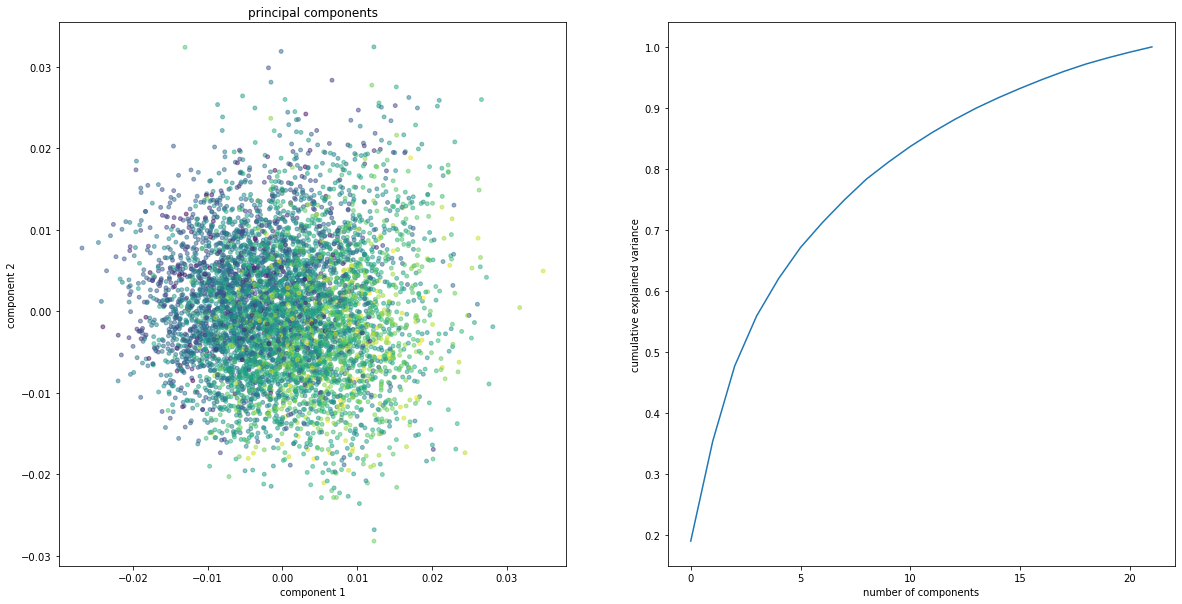

In [46]:
pca_fig = PCA().fit(X_loading)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(X_loadings_PCtransform[:, 0], X_loadings_PCtransform[:, 1], alpha=0.5, 
              c = y.age.astype('category'), s = 15)

#plt.axis('equal')
ax[0].set(xlabel='component 1', ylabel='component 2',
          title='principal components')
pca_fig = PCA().fit(X_loading)
ax[1].plot(np.cumsum(pca_fig.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Nothing really observable here, even with age as category for the colors. And we see, we need more components to capture a meaningful amount of variance in the data.

#### **Final Remarks**
The PCA analysis did not reveal any additional information on the relationship inside the data that could help with the classification of the age group. Also, the first two dimensions did not explain very much of the variance in the data, also seen in the cumulative variance explanation plot. 

Even with a complex model like a Multi-layer perceptron that can model non-linear relationships there was no evidence that it performed substantially better than a simple linear regression model defined in the beginning. Therefore, our MLP model does not seem to provide any grounds for adding additional explanatory power for age, let alone for the assessment scores.

## Model Comparison with other Members of Group

In [47]:
# the best MLPRegressor model found so far for predicting age was the MLPRegressor with the lbfgs solver 
# and including all features. We'll add a bit on the max_iter just to be safe to get the most out of it.
final_model = MLPRegressor(hidden_layer_sizes=(hls,hls), solver='lbfgs', random_state=10, max_iter=1000, alpha=0.001)

seed = 7
scoring = 'r2'
kfold = KFold(n_splits=10, random_state=seed)
cv_results = cross_val_score(final_model, X_fnc_loading, y['age'], cv=kfold, scoring=scoring)


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_ite

R2 (MPLRegressor): 0.515636 (0.029678)


/Users/tydingsmcclary/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [59]:
msg = "mean R2 from cross validation scores (std): %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

mean R2 from cross validation scores (std): 0.515636 (0.029678)


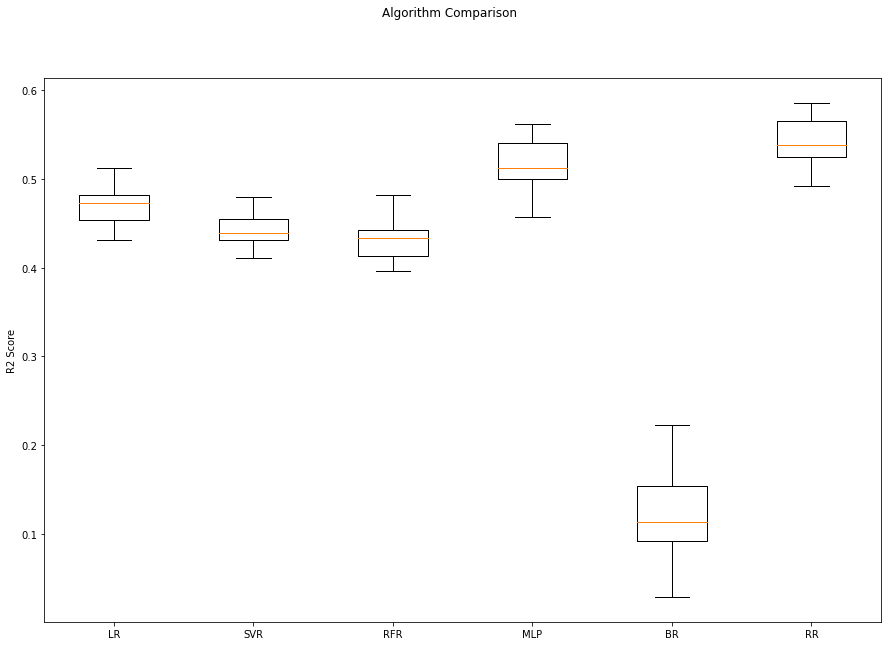

In [57]:
###########################################################################################################
#                                     Collaborative Model Comparison                                      #
# After completing our individual projects above, students who used the same kaggle dataset collaborated  #
# to produce a model comparison between these different regression models, which can be shown below. We   #
# will only be looking at the prediction of age for the comparison:                                       #

results = [
    [0.48038686, 0.44722758, 0.47229537, 0.43149557, 0.48267628, 0.47303389,
       0.47288577, 0.43150015, 0.50556724, 0.51195019], # LinearRegression
    [0.4330323 , 0.4415893 , 0.43576118, 0.41260509, 0.45900908,
       0.44424805, 0.4300585 , 0.41139041, 0.47555739, 0.480079  ], #SVR
    [0.43819714, 0.40940325, 0.45465441, 0.40138206, 0.43437831,
       0.44386384, 0.42308454, 0.39606003, 0.48182481, 0.43259663], #RandomForestRegressor
    [0.48602632, 0.50945147, 0.54282255, 0.51462939, 0.54125916,
        0.50663771, 0.49722094, 0.45733866, 0.53932954, 0.56163937], # MLPRegressor
    [0.02901306, 0.15196958, 0.08661957, 0.1940907 , 0.11258754,
        0.11474175, 0.15555495, 0.10880699, 0.03113268, 0.22320099], # BaggingRegressor
    [0.5222,0.5109,0.5340,0.4915,0.5440,0.5819,0.5384,0.5855,0.5720,0.5368] #RidgeRegressions
]
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(["LR", "SVR", "RFR", "MLP", "BR", "RR"])
plt.ylabel("R2 Score")
plt.show()

### <u>**Conclusion Model Comparison**</u>

After comparing all R2 cross validation scores of the different models, it seems like the Ridge Regression is the best option to go here. Interestingly enough, using a Linear Regression is still the 3rd best option here, even though being the most simple model. As the ridge regression is, simply put, a linear regression with an extra penalty for  high weights, it seems like this improves the R2 score with adding the least complexity. In the end though, no model exceeded an R2 score of 0.6. 